In [1]:
# Vanilla imports
import numpy as np
import matplotlib.pyplot as plt

# Chocolate imports
from src.Calculators.ray_maker import find_observer, ray_maker
from src.Luminosity.thermR import calc_thermr, get_thermr
from src.Opacity.opacity_table import opacity

# Constants
c = 2.99792458e10 #[cm/s]
h = 6.62607015e-27 #[gcm^2/s]
Kb = 1.380649e-16 #[gcm^2/s^2K]
alpha = 7.5646 * 10**(-15) # radiation density [erg/cm^3K^4]
Rsol_to_cm = 6.957e10

In [2]:
def log_array(n_min, n_max, lenght):
    x_min = np.log10(n_min)
    x_max = np.log10(n_max)
    x_arr = np.linspace(x_min, x_max , num = lenght)
    return x_arr

def select_fix(m):
    if m == 4:
        snapshots = [233, 254, 263, 277 , 293, 308, 322]
        days = [1, 1.2, 1.3, 1.4, 1.56, 1.7, 1.8] 
    if m == 6:
        snapshots = [881] #[844, 881, 925, 950]
        days = [1.1] #[1, 1.1, 1.3, 1.4] #t/t_fb
    return snapshots, days

def planck(Temperature: float, n: float) -> float:
    """ Planck function in a cell. It needs temperature and frequency. """
    const = 2*h/c**2
    fun = const * n**3 / (np.exp(h*n/(Kb*Temperature))-1)

    return fun

def luminosity_n(Temperature: float, Density: float, tau: float, volume: float, n: float):
    """ Luminosity in a cell: L_ni = \epsilon e^(-\tau) B_ni / B where  
    B = \sigma T^4/\pi"""
    T_high = np.exp(17.87)
    if Temperature > T_high:
        k_planck = opacity(T_high, Density, 'planck', ln = False)
    else:
        k_planck = opacity(Temperature, Density, 'planck', ln = False)

    L = 4  * np.pi * k_planck * volume * np.exp(-tau) * planck(Temperature, n)
    return L

def normalisation(L_x: np.array, x_array: np.array, luminosity_fld: float) -> float:
    """ Given the array of luminosity L_x computed over 10^{x_array} (!!!), 
    find the normalisation constant from FLD model used for L_tilde_nu. """  
    xLx =  10**(x_array) * L_x
    L = np.trapz(xLx, x_array) 
    L *= np.log(10)
    norm = luminosity_fld / L
    return norm

In [3]:
m = 6
n_min = 6e13
n_max = 3e18
n_spacing = 100
x_arr = log_array(n_min, n_max, n_spacing)

# Load data for normalization
fld_data = np.loadtxt('data/new_reddata_m'+ str(m) +'.txt')
luminosity_fld_fix = fld_data[1]
n_arr = 10**x_arr

#%% Get thermalisation radius
fixes, days = select_fix(m)

In [4]:
fix = 881
index_norm = 1
rays_T, rays_den, rays, radii, thetas, phis  = ray_maker(fix, m, select = True)

/Users/paolamartire/miniconda3/envs/tde_comparison/lib/python3.9/site-packages/numba/core/ir_utils.py:2149: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'observers' of function 'THROUPLE_S_CASTERS'.

For more information visit https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "src/Calculators/legion_of_casters.py", line 12:
@numba.njit
def THROUPLE_S_CASTERS(radii, R,
^

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))


In [5]:
rays_tau, thermr, cumulative_taus = get_thermr(rays_T, rays_den, radii)

In [6]:
dr = radii[1] - radii[0]
volume = 4 * np.pi * radii**2 * dr  / 192   
lum_rays = []      
lum_n = np.zeros(len(x_arr))

for j in range(192):
    print('ray :', j)
    lum_single_ray = np.zeros(len(n_arr))
    for i in range(len(cumulative_taus[j])):        
        # Temperature, Density and volume: np.array from near to the BH
        # to far away. 
        # Thus we will use negative index in the for loop.
        # tau: np.array from outside to inside.
        reverse_idx = -i -1
        T = rays_T[j][reverse_idx]
        rho = rays_den[j][reverse_idx] 
        opt_depth = cumulative_taus[j][i]
        cell_vol = volume[reverse_idx]
        # print('pure tau: ', opt_depth)
        # print('T:', T)
        # print('rho: ', rho)
        
        # Ensure we can interpolate
        T_low = np.exp(8.666)
        T_high = np.exp(17.87)
        rho_low = np.exp(-49.2)
        
        # Out of table
        if rho < rho_low:
            continue
        
        # Opaque
        if T < T_low:
            print('low')
            continue         
        
        for index, n in enumerate(n_arr): #we need linearspace
            lum_n_cell = luminosity_n(T, rho, opt_depth, cell_vol, n)
            lum_n[index] += lum_n_cell
            lum_single_ray[index] += lum_n_cell
    lum_rays.append(lum_single_ray)
               

ray : 0
ray : 1
ray : 2
ray : 3
ray : 4
ray : 5
ray : 6
ray : 7
ray : 8
ray : 9
ray : 10
ray : 11
ray : 12
ray : 13
ray : 14
ray : 15
ray : 16
ray : 17
ray : 18
ray : 19
ray : 20
ray : 21
ray : 22
ray : 23
ray : 24
ray : 25
ray : 26
ray : 27
ray : 28
ray : 29
ray : 30
ray : 31
ray : 32
ray : 33
ray : 34
ray : 35
ray : 36
ray : 37
ray : 38
ray : 39
ray : 40
ray : 41
ray : 42
ray : 43
ray : 44
ray : 45
ray : 46
ray : 47
ray : 48
ray : 49
ray : 50
ray : 51
ray : 52
ray : 53
ray : 54
ray : 55
ray : 56
ray : 57
ray : 58
ray : 59
ray : 60
ray : 61
ray : 62
ray : 63
ray : 64
ray : 65
ray : 66
ray : 67
ray : 68
ray : 69
ray : 70
ray : 71
ray : 72
ray : 73
ray : 74
ray : 75
ray : 76
ray : 77
ray : 78
ray : 79
ray : 80
ray : 81
ray : 82
ray : 83
ray : 84
ray : 85
ray : 86
ray : 87
ray : 88


/var/folders/s6/3n46ppqn3jx7765w8c686c740000gn/T/ipykernel_17165/3862389994.py:19: RuntimeWarning: overflow encountered in exp
  fun = const * n**3 / (np.exp(h*n/(Kb*Temperature))-1)


ray : 89
ray : 90
ray : 91
ray : 92
ray : 93
ray : 94
ray : 95
ray : 96
ray : 97
ray : 98
ray : 99
ray : 100
ray : 101
ray : 102
ray : 103
ray : 104
ray : 105
ray : 106
ray : 107
ray : 108
ray : 109
ray : 110
ray : 111
ray : 112
ray : 113
ray : 114
ray : 115
ray : 116
ray : 117
ray : 118
ray : 119
ray : 120
ray : 121
ray : 122
ray : 123
ray : 124
ray : 125
ray : 126
ray : 127
ray : 128
ray : 129
ray : 130
ray : 131
ray : 132
ray : 133
ray : 134
ray : 135
ray : 136
ray : 137
ray : 138
ray : 139
ray : 140
ray : 141
ray : 142
ray : 143
ray : 144
ray : 145
ray : 146
ray : 147
ray : 148
ray : 149
ray : 150
ray : 151
ray : 152
ray : 153
ray : 154
ray : 155
ray : 156
ray : 157
ray : 158
ray : 159
ray : 160
ray : 161
ray : 162
ray : 163
ray : 164
ray : 165
ray : 166
ray : 167
ray : 168
ray : 169
ray : 170
ray : 171
ray : 172
ray : 173
ray : 174
ray : 175
ray : 176
ray : 177
ray : 178
ray : 179
ray : 180
ray : 181
ray : 182
ray : 183
ray : 184
ray : 185
ray : 186
ray : 187
ray : 188
ray : 189
r

In [7]:
print(np.shape(lum_rays))

(192, 100)


In [8]:
# Normalise with the bolometric luminosity from red curve (FLD)
const_norm = normalisation(lum_n, x_arr, luminosity_fld_fix[1])
lum_tilde_n = lum_n * const_norm

In [9]:
print(const_norm)

1.2694010884726974


In [10]:
for i in range(len(lum_rays)):
    for j in range(len(lum_rays[i])):
        lum_rays[i][j] *= const_norm

In [11]:
nlum = n_arr * lum_tilde_n

In [12]:
test = np.zeros(len(n_arr))
for j in range(len(n_arr)):
    for i in range(29,52):
        test[j] += lum_rays[i][j]

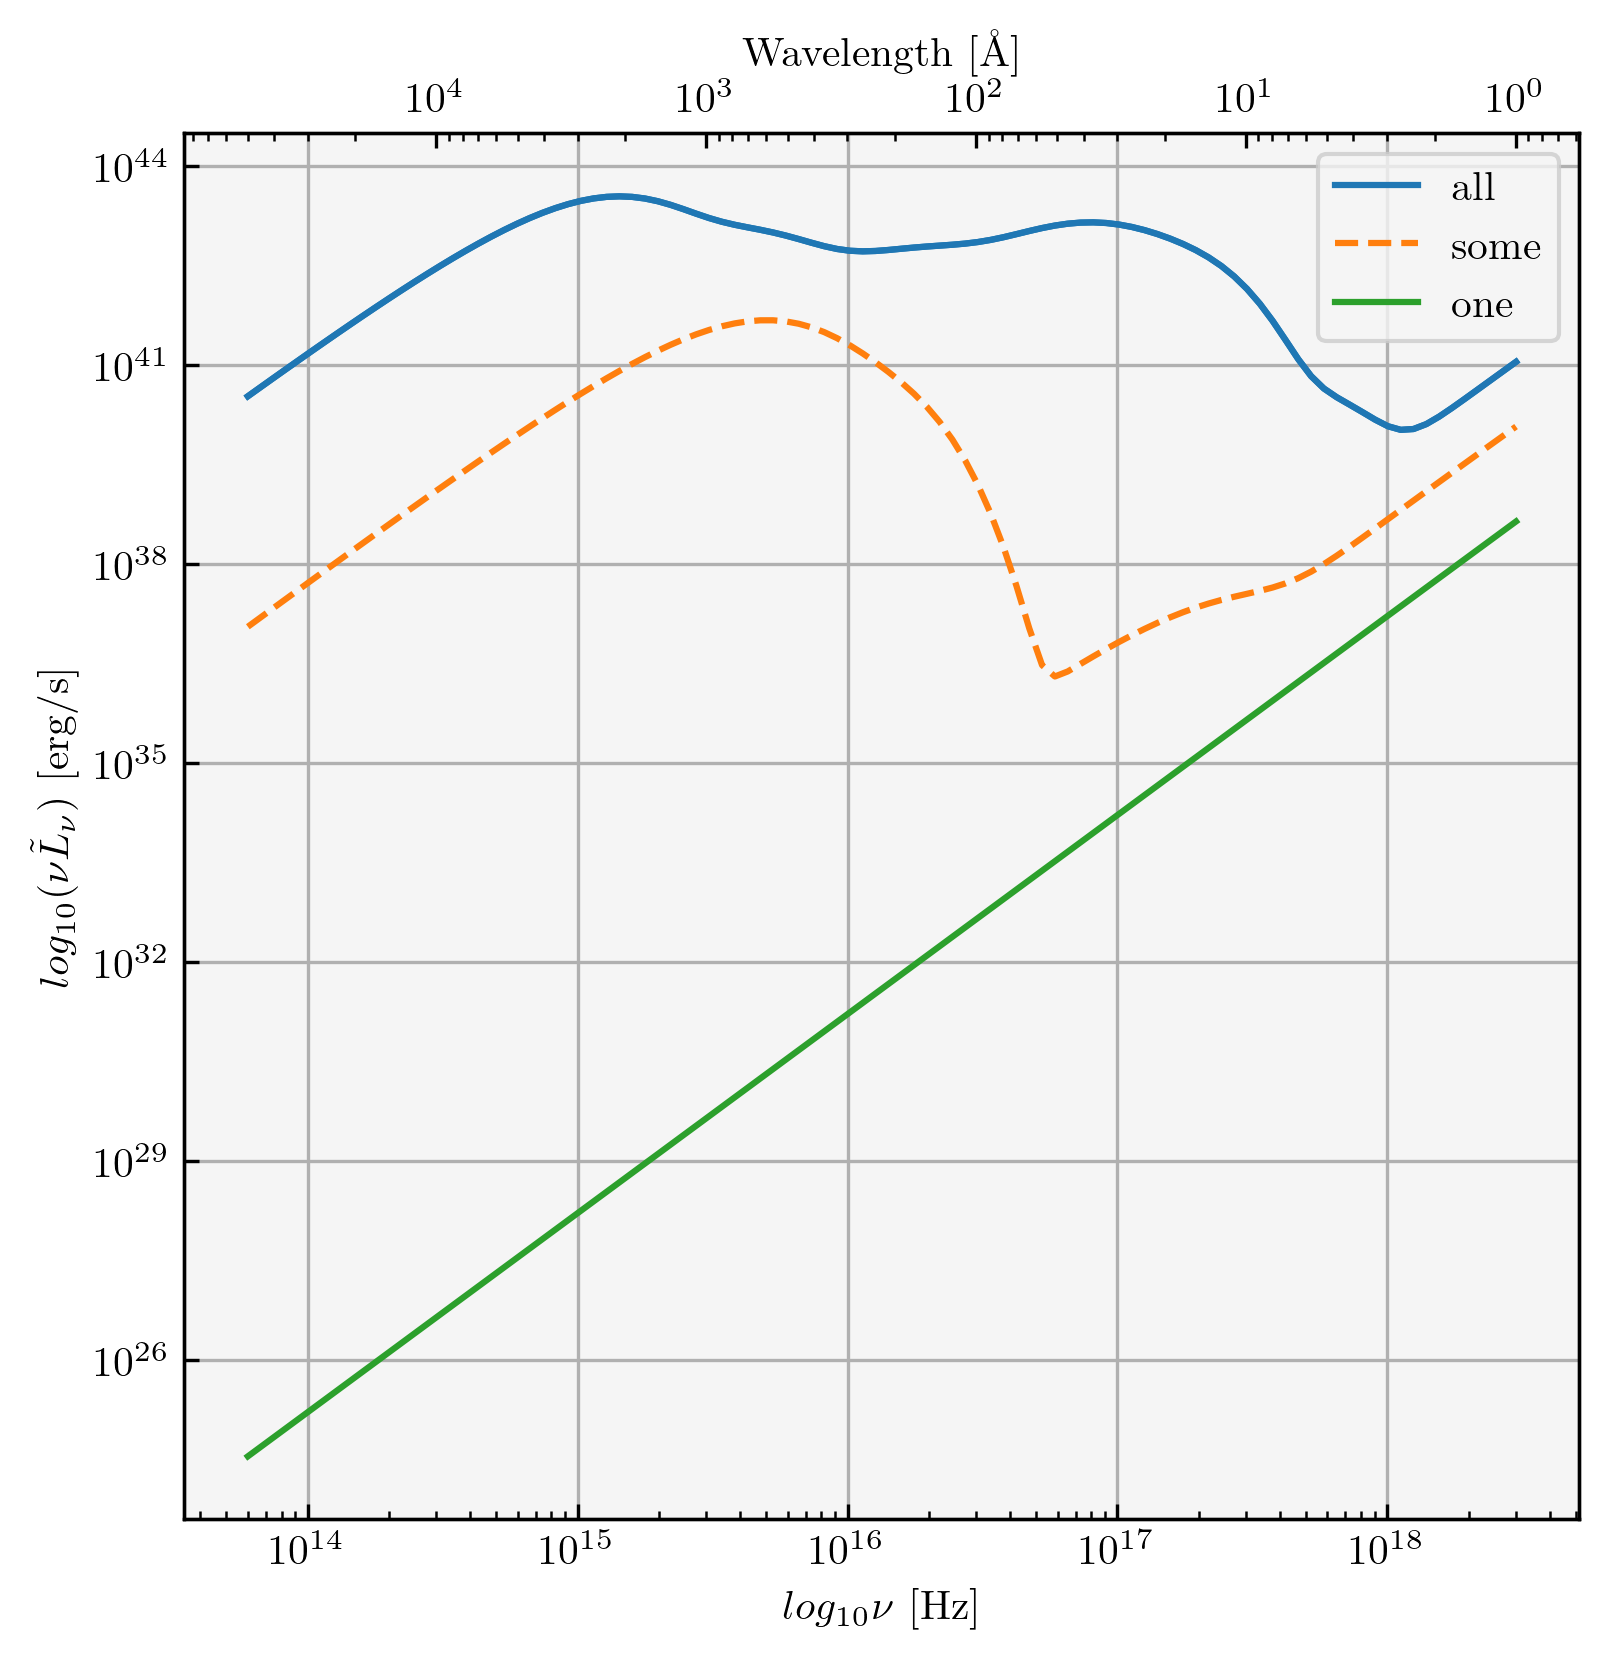

In [13]:
fig, ax1 = plt.subplots( figsize = (6,6) )
ax1.plot(n_arr, nlum, label = 'all')
ax1.plot(n_arr, n_arr * test, '--', label = 'some')
ax1.plot(n_arr, n_arr * lum_rays[1], label = 'one')
ax2 = ax1.twiny()
ax1.set_xlabel(r'$log_{10}\nu$ [Hz]')
ax1.set_ylabel(r'$log_{10}(\nu\tilde{L}_\nu)$ [erg/s]')
ax1.loglog()
ax1.grid()
wavelength = np.divide(c, n_arr) * 1e8 # A
ax2.plot(wavelength, nlum)
ax2.invert_xaxis()
ax2.loglog()
ax2.set_xlabel(r'Wavelength [\AA]')
ax1.legend()
plt.show()